#   LangGraph 활용 - 사용자 개입 (Human-in-the-Loop)

---

## 환경 설정 및 준비

`(1) Env 환경변수`

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [1]:
import os
from glob import glob

from pprint import pprint
import json

`(3) Langsmith tracing 설정`

In [3]:
# Langsmith tracing 여부를 확인 (true: langsmith 추척 활성화, false: langsmith 추척 비활성화)
import os
print(os.getenv('LANGSMITH_TRACING'))

true  # 모니터링 활성화할꺼냐


---

## **Human-in-the-Loop (사용자 개입)**

- **HITL**는 AI 시스템에 인간의 판단과 전문성을 통합

- **Breakpoints**로 특정 단계에서 실행 중지 가능
    - **Breakpoint**는 LangGraph의 **체크포인트 기능** 기반으로 작동하는 시스템
    - 각 노드 실행 후 그래프의 상태를 **스레드에 저장**하여 나중에도 접근 가능
    - 그래프 실행을 특정 지점에서 **일시 중지**하고 사용자 승인 후 재개 가능

- 사용자의 **입력**이나 **승인**을 기다리는 패턴으로 작동

- 시스템 결정에 대한 **인간의 통제**와 **검증** 보장

`(1) 문서 생성 및 검토 시스템`

- **문서 생성** 단계에서 AI가 초안 작성
- **검토 단계**에서 인간 전문가가 내용 검증
- **수정 요청**시 AI가 피드백 반영하여 개선

In [4]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage
from IPython.display import Image, display

# 상태 정의
class State(MessagesState):
    draft: str     # 초안
    is_approved: bool  # 승인 여부_(true or false)
    feedback: str   # 피드백


def generate_draft(state: State):
    """초안 생성"""
    draft = "이것은 AI가 생성한 문서 초안입니다."
    return {
        "draft": draft,
        "messages": [AIMessage(content=f"초안이 생성되었습니다:\n\n{draft}")]
    }

def review_draft(state: State):
    """초안 검토"""
    return {
        "messages": [AIMessage(content="초안을 검토해주세요. 승인하시겠습니까?")]
    }

def process_feedback(state: State):
    """피드백 처리"""
    if state["is_approved"]:
        return {
            "messages": [AIMessage(content="문서가 승인되었습니다.")]
        }
    else:
        return {
            "messages": [AIMessage(content=f"문서를 수정하였습니다. 피드백: {state['feedback']}")]
        }

def should_continue(state: State):  # 조건부 엣지
    """계속 진행 여부 결정"""
    if not state.get("is_approved", False): #상태로 부터 승인  false면-> review 로 분기
        return "review"                     # 아니면  end
    return "end"


# 그래프 설정
builder = StateGraph(State)

# 노드 추가
builder.add_node("generate", generate_draft)
builder.add_node("review", review_draft)
builder.add_node("process", process_feedback)

# 엣지 추가
builder.add_edge(START, "generate")
builder.add_edge("generate", "review")
builder.add_edge("review", "process")
builder.add_conditional_edges(
    "process",
    should_continue,
    {
        "review": "review",
        "end": END
    }
)


`(2) 메모리 설정 및 컴파일`

- **메모리 객체** 생성: `memory = MemorySaver()`
- **워크플로우 컴파일**: `graph.compile()` 메서드 사용
- **프로세스 중단점** 설정: `interrupt_before=["process"]`


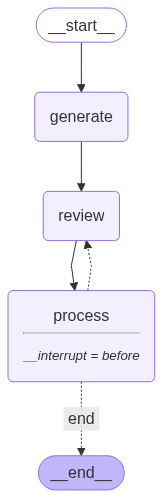

In [5]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 저장소 설정
memory = MemorySaver()  # 체크포인트 필요

# 그래프 컴파일

# 프로세스 노드가 실행되기전 항상 먼전 브레이크포인트 생성. interrupt_before에 추가해둔 노드 
graph = builder.compile(checkpointer=memory, interrupt_before=["process"])  

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png())) # 머메이드로 ..

`(3) 그래프 실행`

In [7]:
# 최초 메시지 및 스레드 설정 
config = {"configurable": {"thread_id": "1"}}
initial_input = {
    "messages": [HumanMessage(content="간단한 이메일 초안을 작성해주세요.")]
}

# 첫 번째 실행 - 중단점에서 실행을 멈춤 
for event in graph.stream(initial_input, config):
    print(f"Event: {event}")

Event: {'generate': {'draft': '이것은 AI가 생성한 문서 초안입니다.', 'messages': [AIMessage(content='초안이 생성되었습니다:\n\n이것은 AI가 생성한 문서 초안입니다.', additional_kwargs={}, response_metadata={}, id='6c30eb6a-b5e4-4a39-8739-5eec42ef2d68')]}}
Event: {'review': {'messages': [AIMessage(content='초안을 검토해주세요. 승인하시겠습니까?', additional_kwargs={}, response_metadata={}, id='6e0118a5-45bc-4242-813f-eb6d95889d47')]}}
Event: {'__interrupt__': ()}


In [8]:
# 현재 상태 - 그래프 체크포인트 확인
current_state = graph.get_state(config)

print(f"승인 여부: {current_state.values.get('is_approved')}")
print("-"*100)
print(f"초안: {current_state.values.get('draft')}")
print("-"*100)
print(f"피드백: {current_state.values.get('feedback')}")
print("-"*100)
print("메시지: ")
for msg in current_state.values.get('messages', []):
    print(f"{msg.type}: {msg.content}")
    print("*"*100)

승인 여부: None
----------------------------------------------------------------------------------------------------
초안: 이것은 AI가 생성한 문서 초안입니다.
----------------------------------------------------------------------------------------------------
피드백: None
----------------------------------------------------------------------------------------------------
메시지: 
human: 간단한 이메일 초안을 작성해주세요.
****************************************************************************************************
ai: 초안이 생성되었습니다:

이것은 AI가 생성한 문서 초안입니다.
****************************************************************************************************
ai: 초안을 검토해주세요. 승인하시겠습니까?
****************************************************************************************************
human: 간단한 이메일 초안을 작성해주세요.
****************************************************************************************************
ai: 초안이 생성되었습니다:

이것은 AI가 생성한 문서 초안입니다.
*******************************************************************************

In [9]:
# 다음에 실행될 노드를 확인 
current_state.next

('process',)

`(4) 사용자 개입 (HITL): 거부`

- 사용자가 승인을 해주지 않는 경우, 피드백을 통해 다시 생성

In [10]:
# 사용자 피드백 제공 (거부)
human_feedback = {
    "is_approved": False,
    "feedback": "문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요."
}
graph.update_state(config, human_feedback)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03b93e-7a3a-6c51-8007-02f0baf67f16'}}

In [11]:
# 현재 상태 - 그래프 체크포인트 확인
current_state = graph.get_state(config)

print(f"승인 여부: {current_state.values.get('is_approved')}")
print("-"*100)
print(f"피드백: {current_state.values.get('feedback')}")

승인 여부: False
----------------------------------------------------------------------------------------------------
피드백: 문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.


In [12]:
# 실행 재개 (입력값을 None으로 지정하면 중단점부터 실행하는 의미)
for event in graph.stream(None, config):  
    print(f"Event: {event}")

Event: {'process': {'messages': [AIMessage(content='문서를 수정하였습니다. 피드백: 문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.', additional_kwargs={}, response_metadata={}, id='cf79c8d4-bf00-4db6-9c26-04b5fe9009e0')]}}
Event: {'review': {'messages': [AIMessage(content='초안을 검토해주세요. 승인하시겠습니까?', additional_kwargs={}, response_metadata={}, id='20986e05-f5af-4b08-b530-0b5ffe1f828a')]}}
Event: {'__interrupt__': ()}


In [13]:
# 현재 상태 - 그래프 체크포인트 확인
current_state = graph.get_state(config)

print(f"승인 여부: {current_state.values.get('is_approved')}")
print("-"*100)
print(f"초안: {current_state.values.get('draft')}")
print("-"*100)
print(f"피드백: {current_state.values.get('feedback')}")
print("-"*100)
print("메시지: ")
for msg in current_state.values.get('messages', []):
    print(f"{msg.type}: {msg.content}")
    print("*"*100)

승인 여부: False
----------------------------------------------------------------------------------------------------
초안: 이것은 AI가 생성한 문서 초안입니다.
----------------------------------------------------------------------------------------------------
피드백: 문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.
----------------------------------------------------------------------------------------------------
메시지: 
human: 간단한 이메일 초안을 작성해주세요.
****************************************************************************************************
ai: 초안이 생성되었습니다:

이것은 AI가 생성한 문서 초안입니다.
****************************************************************************************************
ai: 초안을 검토해주세요. 승인하시겠습니까?
****************************************************************************************************
human: 간단한 이메일 초안을 작성해주세요.
****************************************************************************************************
ai: 초안이 생성되었습니다:

이것은 AI가 생성한 문서 초안입니다.
*******************************************

In [14]:
# 다음에 실행될 노드를 확인 
current_state.next

('process',)

`(5) 사용자 개입 (HITL): 승인`

- 사용자가 승인을 해서 최종 답변을 생성하고 종료

In [15]:
# 사용자 피드백 제공 (승인)
human_feedback = {
    "is_approved": True,
    "feedback": "내용에 만족합니다."
}
graph.update_state(config, human_feedback)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03b944-1990-6d7e-800a-e0d159291ade'}}

In [16]:
# 현재 상태 - 그래프 체크포인트 확인
current_state = graph.get_state(config)

print(f"승인 여부: {current_state.values.get('is_approved')}")
print("-"*100)
print(f"피드백: {current_state.values.get('feedback')}")

승인 여부: True
----------------------------------------------------------------------------------------------------
피드백: 내용에 만족합니다.


In [17]:
# 실행 재개 (입력값을 None으로 지정하면 중단점부터 실행하는 의미)
for event in graph.stream(None, config):  # 중단점 부터 실행시, graph 실행하는 메소드에서 입력값 run
    print(f"Event: {event}")

Event: {'process': {'messages': [AIMessage(content='문서가 승인되었습니다.', additional_kwargs={}, response_metadata={}, id='20ea0629-9540-4c72-97de-b04b14cbccef')]}}


In [18]:
# 현재 상태 - 그래프 체크포인트 확인
current_state = graph.get_state(config)

print(f"승인 여부: {current_state.values.get('is_approved')}")
print("-"*100)
print(f"초안: {current_state.values.get('draft')}")
print("-"*100)
print(f"피드백: {current_state.values.get('feedback')}")
print("-"*100)
print("메시지: ")
for msg in current_state.values.get('messages', []):
    print(f"{msg.type}: {msg.content}")
    print("*"*100)

승인 여부: True
----------------------------------------------------------------------------------------------------
초안: 이것은 AI가 생성한 문서 초안입니다.
----------------------------------------------------------------------------------------------------
피드백: 내용에 만족합니다.
----------------------------------------------------------------------------------------------------
메시지: 
human: 간단한 이메일 초안을 작성해주세요.
****************************************************************************************************
ai: 초안이 생성되었습니다:

이것은 AI가 생성한 문서 초안입니다.
****************************************************************************************************
ai: 초안을 검토해주세요. 승인하시겠습니까?
****************************************************************************************************
human: 간단한 이메일 초안을 작성해주세요.
****************************************************************************************************
ai: 초안이 생성되었습니다:

이것은 AI가 생성한 문서 초안입니다.
*************************************************************************

In [19]:
# 다음에 실행될 노드를 확인 
current_state.next

()